In [1]:
import deepSI
from deepSI.systems.System import System, System_Deriv, System_data
import numpy as np
from matplotlib import pyplot as plt
from deepSI.systems import ball_in_box_video_system

## Generate data

In [2]:
if False:
    np.random.seed(seed=42)
    urand = lambda L: np.random.uniform(low=sys.action_space.low, high=sys.action_space.high, size=(L,2))
    sys = ball_in_box_video_system()
    train = System_data(u=urand(30000))
    val = System_data(u=urand(5000))
    test = System_data(u=urand(5000))
    train = sys.apply_experiment(train)
    val = sys.apply_experiment(val)
    test = sys.apply_experiment(test)
    train.save('ball-in-box-data/train')
    val.save('ball-in-box-data/val')
    test.save('ball-in-box-data/test')
else:
    train = deepSI.load_system_data('ball-in-box-data/train.npz')
    val = deepSI.load_system_data('ball-in-box-data/val.npz')
    test = deepSI.load_system_data('ball-in-box-data/test.npz')

## Fit state-space encoder

In [3]:
if False:
    fit_sys = deepSI.fit_systems.System_encoder(nx=6, na=5, nb=5)
    fit_sys.use_norm = False #the norm will not be fitted automatically
    fit_sys.norm.y0 = np.mean(train.y) #fit global values
    fit_sys.norm.ystd = np.std(train.y)
    fit_sys.norm.u0 = np.mean(train.u,axis=0)
    fit_sys.norm.ustd = np.std(train.u,axis=0)
    fit_sys.fit(train.flatten(),verbose=2, epochs=15*600, Loss_kwargs=dict(nf=50),sim_val=val.flatten())
#     fit_sys.save_system('systems/SS-encoder-sys') #prevent accidental overwrite is bad
else:
    fit_sys = deepSI.load_system('systems/SS-encoder-sys')


## Fit Input-output autoencoder

Reproduction of: Wahlstrom, N., Schon, T.B., and Deisenroth, M.P.
(2015). Learning deep dynamical models from image
pixels. IFAC-PapersOnLine, 48(28), 1059–1064.

In [4]:
if False:
    fit_sys_auto = deepSI.fit_systems.System_IO_auto_encoder(nz=6, na=5, nb=5)
    fit_sys_auto.use_norm = False #the norm will not be fitted automatically
    fit_sys_auto.norm.y0 = np.mean(train.y) #fit global values
    fit_sys_auto.norm.ystd = np.std(train.y)
    fit_sys_auto.norm.u0 = np.mean(train.u,axis=0)
    fit_sys_auto.norm.ustd = np.std(train.u,axis=0)
    fit_sys_auto.fit(train.flatten(),verbose=2, epochs=15*600, Loss_kwargs=dict(),sim_val=val.flatten())
#     fit_sys_auto.save_system('systems/IO-autoencoder-sys') #overwrite is bad
else:
    fit_sys_auto = deepSI.load_system('systems/IO-autoencoder-sys')


In [5]:
test_SS_encoder, test_IO_auto = fit_sys.apply_experiment(test.flatten()).reshape_as(test), fit_sys_auto.apply_experiment(test.flatten()).reshape_as(test)
train_SS_encoder, train_IO_auto = fit_sys.apply_experiment(train.flatten()).reshape_as(train), fit_sys_auto.apply_experiment(train.flatten()).reshape_as(train)

In [6]:
print(' ########## Train #############')
print(f'\t IO auto encoder RMS = {train_IO_auto.RMS(train):.4}, NRMS = {train_IO_auto.RMS(train)/np.std(test.y):.2%}')
print(f'\t SS      encoder RMS = {train_SS_encoder.RMS(train):.4}, NRMS = {train_SS_encoder.RMS(train)/np.std(test.y):.2%}')

print('\n ########## Test ############')
print(f'\t IO auto encoder RMS = {test_IO_auto.RMS(test):.4}, NRMS = {test_IO_auto.RMS(test)/np.std(test.y):.2%}')
print(f'\t SS      encoder RMS = {test_SS_encoder.RMS(test):.4}, NRMS = {test_SS_encoder.RMS(test)/np.std(test.y):.2%}')


 ########## Train #############
	 IO auto encoder RMS = 0.01242, NRMS = 6.08%
	 SS      encoder RMS = 0.01164, NRMS = 5.69%

 ########## Test ############
	 IO auto encoder RMS = 0.01503, NRMS = 7.35%
	 SS      encoder RMS = 0.01343, NRMS = 6.57%


## Validation simulation error during training

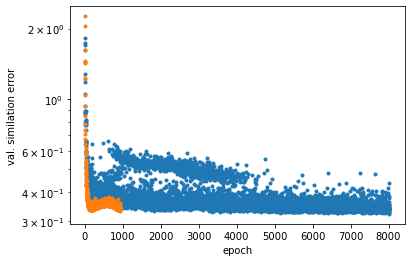

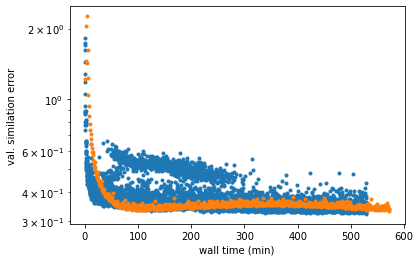

In [7]:
plt.semilogy(fit_sys_auto.Loss_val,'.')
plt.semilogy(np.array(fit_sys.Loss_val),'.')
plt.xlabel('epoch')
plt.ylabel('val. similation error')
plt.show()
plt.semilogy(fit_sys_auto.time/60,fit_sys_auto.Loss_val,'.')
plt.semilogy(np.array(fit_sys.time)/60,np.array(fit_sys.Loss_val),'.')
plt.xlabel('wall time (min)')
plt.ylabel('val. similation error')
plt.show()

## Figure 3: Time compare

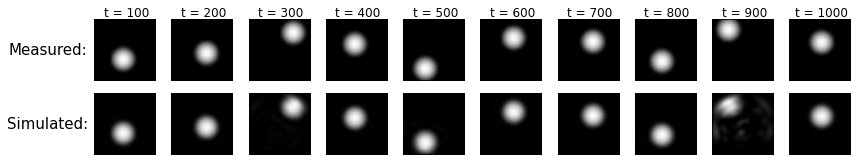

In [8]:
Xmax,Ymax = test_SS_encoder.y[0].shape
Y = test_SS_encoder.y[100]
def ball_show(Y,t,text=True):
    Y = np.clip(Y,0,1)
    plt.imshow(Y,cmap='gray',interpolation='bicubic',origin='lower')
    plt.plot(np.array([0,Ymax,Ymax,0,0])-0.5,np.array([0,0,Xmax,Xmax,0])-0.5,'k')
    if text: plt.text(Ymax/2,Xmax*1.075,'t = {}'.format(t),horizontalalignment='center',verticalalignment='center',fontdict=dict(size=12))
    plt.axis('off')
    #add other things

    
offset = 26 #show extrapolation in 900
tlist = list(range(100,1001,100))
plt.figure(figsize=(15,2.5))
plt.subplot(2,len(tlist)+1,1)
plt.text(0.5,0.5,'Measured:',horizontalalignment='center',verticalalignment='center',fontdict=dict(size=15))
plt.axis('off')
plt.subplot(2,len(tlist)+1,len(tlist)+1+1)
plt.text(0.5,0.5,'Simulated:',horizontalalignment='center',verticalalignment='center',fontdict=dict(size=15))
plt.axis('off')
for k,t in enumerate(tlist):
    plt.subplot(2,len(tlist)+1,1+k+1)
    ball_show(test.y[t+offset],t)
    plt.subplot(2,len(tlist)+1,(1+len(tlist))+1+k+1)
    ball_show(test_SS_encoder.y[t+offset],t,text=False)
# plt.tight_layout() #does not work
plt.savefig('./figures/strip.jpg',dpi=200)
img0 = plt.imread('./figures/strip.jpg')

#manual tight layout
img = np.mean(img0,axis=2)
xdiffs = np.arange(img.shape[1])[np.mean(img,axis=0)<255]
ydiffs = np.arange(img.shape[0])[np.mean(img,axis=1)<255]
xmin,xmax = np.min(xdiffs), np.max(xdiffs)
ymin,ymax = np.min(ydiffs), np.max(ydiffs)
plt.imsave('./figures/strip.jpg',img0[ymin-1:ymax+1,xmin-1:xmax+1])
plt.show()

## Figure 4: Error in time

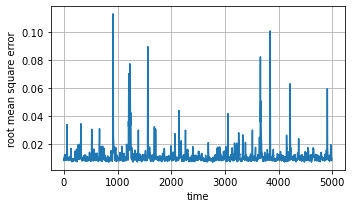

In [9]:
diff = (test_SS_encoder-test)
plt.figure(figsize=(5,3))
plt.plot(np.mean(diff.y[10:]**2,axis=(1,2))**0.5) 
plt.ylabel('root mean square error')
plt.xlabel('time')
plt.tight_layout()
plt.grid()
plt.savefig('./figures/time-square-error.pdf')
plt.show()

## Figure 5: n-step error

The error one expect to find after taking n steps.

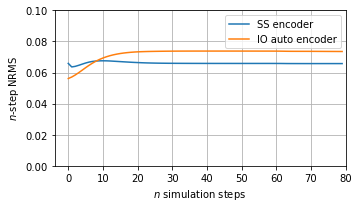

In [10]:
plt.figure(figsize=(5,3))
plt.plot(fit_sys.n_step_error(test.flatten(),RMS=False,nf=80),label='SS encoder') #uses the norm
plt.plot(fit_sys_auto.n_step_error(test.flatten(),RMS=False,nf=80),label='IO auto encoder') #uses the norm
# plt.plot(fit_sys.n_step_error(train[:5000].flatten(),RMS=False,nf=80),label='train') #uses the norm
plt.ylim(0,0.1)
plt.ylabel('$n$-step NRMS')
plt.xlabel('$n$ simulation steps')
plt.tight_layout()
plt.legend()
plt.grid()
plt.savefig('./figures/n-step-error.pdf')
plt.xlim(None,80)
plt.show()


## Video's

In [11]:
# test_predict.reshape_as(test).to_video(file_name='test-predict-ball-box-2')
# test.to_video(file_name='test-ball-box-2')
#requires cv2
limit = 1500
test[:limit].to_video('videos/test-measured')
test_SS_encoder[:limit].to_video('videos/test-SS-encoder')
test_IO_auto[:limit].to_video('videos/test-IO-autoencoder')

#combined videos
System_data(y=np.concatenate((test.y,test_SS_encoder.y),axis=2))[:limit].to_video(file_name='videos/test-sim-measured-and-SS-encoder')
System_data(y=np.concatenate((test.y,test_SS_encoder.y,test_IO_auto.y),axis=2))[:limit].to_video(file_name='videos/test-sim-measured-SS-encoder-and-IO-auto-encoder')